# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
import random as rnd

import heapq as hp
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [2]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("i.markov") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [4]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
import random as rnd
import sys
import heapq as hp


class Clustering:
    """
    Implement clustering algorithm according
    """




    class HeapElement:
        def __init__(self, key, C1, C2):
            self.key = key
            self.C1 = C1
            self.C2 = C2

        def __cmp__(self, other):
            return cmp(self.key, other.key)

    
    def __init__(self, **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.K = kwargs.get("K")  # desired number of clusters
        distance_str = kwargs.get("distance_func", "euclidian")
        if distance_str == "euclidian":
            self.dist_func = Clustering.euclidian_dist
        elif distance_str == "manhattan":
            self.dist_func == Clustering.manhattan_dist
        else:
            raise Exception("Wrong parameter distance")

        linkage_str = kwargs.get("linkage", "single")  # desired linkage
        if linkage_str == "single":
            self.linkage = Clustering.single_linkage
        elif linkage_str == "complete":
            self.linkage == Clustering.complete_linkage
        elif linkage_str == "average":
            self.linkage == Clustering.average_linkage
        else:
            raise Exception("Wrong parameter linkage")

        return

    #
    # Here are static methods for different distance and linkage calculations
    #
    # default distance is euclidean
    # default linkage is single
    #

    @staticmethod
    def euclidian_dist(x1, x2):
        x1_np = np.asarray(x1)
        x2_np = np.asarray(x2)
        return np.linalg.norm(x1_np - x2_np)

    @staticmethod
    def manhattan_dist(x1, x2):
        x1_np = np.asarray(x1)
        x2_np = np.asarray(x2)
        return np.sum(abs(x1_np - x2_np))

    @staticmethod
    def single_linkage(C1, C2, dist):
        min_ = sys.maxint
        for e1 in C1:
            for e2 in C2:
                d = dist(e1, e2)
                if d < min_:
                    min_ = d
        return min_

    @staticmethod
    def complete_linkage(C1, C2, dist):
        max_ = 0

        for e1 in C1:
            for e2 in C2:
                d = dist(e1, e2)
                if d > max_:
                    max_ = d
        return max_

    @staticmethod
    def average_linkage(C1, C2, dist):
        sum_ = 0

        for e1 in C1:
            for e2 in C2:
                sum_ += dist(e1, e2)

        return sum_ / (len(C1) * len(C2))




    def merge(self, c1, c2):
        x1, x2 = min(c1, c2), max(c1, c2)
        c_del = self.clusters[x2]

        self.clusters[x1].update(self.clusters[x2])
        self.update_for_new_cluster(x1, x2)

        self.clusters.remove(c_del)
        self.number_clusters -= 1
        self.distance = np.delete(self.distance, x2, 0)
        self.distance = np.delete(self.distance, x2, 1)
        return x1, x2

    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.number_clusters = len(x)  # number of clusters in beginning
        self.clusters = []


        for e in x:
            self.clusters.append({tuple(e)}) #insert as sets of tuples
        self.distance = np.full((self.number_clusters, self.number_clusters), np.inf)
        for C in self.clusters:
            self.calc_distance(C)
        return self

    def calc_distance(self, c):
        cluster_number = self.clusters.index(c)
        for i in xrange(cluster_number + 1, self.number_clusters):
            self.distance[cluster_number][i] = self.linkage(self.clusters[i], c, self.dist_func)
        return self

    def update_for_new_cluster(self, x, y):
        for i in xrange(x):
            self.distance[i][x] = self.update(self.distance[i][x], self.distance[i][y], x, y)
        for i in xrange(x + 1, y):
            self.distance[x][i] = self.update(self.distance[x][i], self.distance[i][y], x, y)
        for i in xrange(y, self.number_clusters):
            self.distance[x][i] = self.update(self.distance[x][i], self.distance[y][i], x, y)

    def update(self, d1, d2, x, y):
        if self.linkage == Clustering.single_linkage:
            return min(d1, d2)
        elif self.linkage == Clustering.complete_linkage:
            return max(d1, d2)
        else:
            sum = d1 * len(self.clusters[x]) + d2 * len(self.clusters[y])
            return sum / (len(self.clusters[x]) + len(self.clusters[y]))


    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """

        while len(self.clusters) > self.K:
            C_a = self.distance.argmin() // self.distance.shape[1]
            C_b = self.distance.argmin() % self.distance.shape[1]
            self.merge(C_a, C_b)

        result = []
        for obj in x:
            for i, C in enumerate(self.clusters):
                if tuple(obj) in C:
                    result.append(i)
                    break
        return result

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

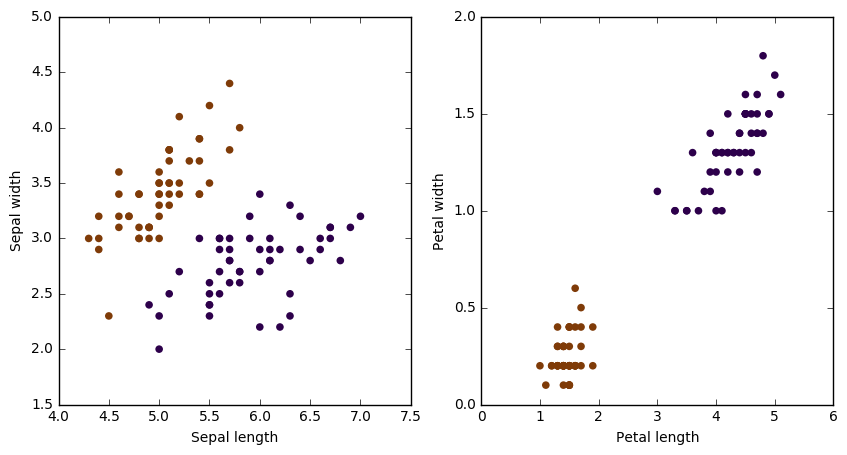

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [6]:
pred_iris = Clustering(K=2).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [80]:
def silhouete(elem, x, y, y_e, dist):
    #i don't know how to do it nice n=with numpy so i do it with cycles
    sums = {}
    counts = {}
    for i,e in enumerate(x):
        if y[i] in sums:
            sums[y[i]] += dist(elem, e)
            counts[y[i]] += 1
        else:
            sums[y[i]] = dist(elem, e)
            counts[y[i]] = 1
    averages = np.full(max(sums.keys()) + 1, np.inf)
    
    for i in sorted(sums):
        averages[i] = sums[i] / counts[i]
 
    a = averages[y_e]
    averages = np.delete(averages, y_e)

    if len(averages) == 0:
        return -1.0
   
    b = min(averages)
    return (b - a)/ max(a,b)
    

In [74]:
def quality(x, y, dist):
    """
    Implement quality criterion of your choice
    """
    silhouetes = np.zeros(len(x))
    for i, e in enumerate(x):
        silhouetes[i] = silhouete(e, x, y, y[i], dist)
    #print silhouetes
    return np.mean(silhouetes)

In [33]:
def samples(x, l):
    result = []
    random_n = np.random.random_integers(0, len(x), l)
    for i in random_n:
        result.append(x[i])
    #hope random is ok and no duplicates there; i could check it with set, but need transform nparray to tuple
    return np.asarray(result)

my_x = samples(x,1000)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 11412 + 1) instead
  app.launch_new_instance()


In [83]:
cls = Clustering(K=20)
y = cls.fit_predict(my_x)
quality(my_x, y, cls.dist_func)

-0.5410812644622397

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

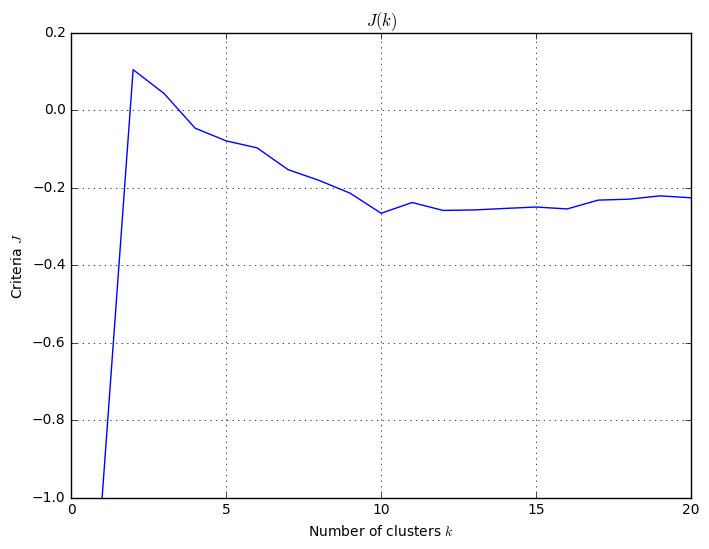

In [24]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(K=k)
    y = cls.fit_predict(my_x)
    criteria[i] = quality(my_x, y, cls.dist_func)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

Методом локтя определяем количество кластеров = 10

In [84]:
k = 10
cls = Clustering(K=k)
y = cls.fit_predict(x)

In [90]:
import pickle
with open("clusters.pickle", "wb") as out:
    pickle.dump(y, out)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11412
[t-SNE] Computed conditional probabilities for sample 2000 / 11412
[t-SNE] Computed conditional probabilities for sample 3000 / 11412
[t-SNE] Computed conditional probabilities for sample 4000 / 11412
[t-SNE] Computed conditional probabilities for sample 5000 / 11412
[t-SNE] Computed conditional probabilities for sample 6000 / 11412
[t-SNE] Computed conditional probabilities for sample 7000 / 11412
[t-SNE] Computed conditional probabilities for sample 8000 / 11412
[t-SNE] Computed conditional probabilities for sample 9000 / 11412
[t-SNE] Computed conditional probabilities for sample 10000 / 11412
[t-SNE] Computed conditional probabilities for sample 11000 / 11412
[t-SNE] Computed conditional probabilities for sample 11412 / 11412
[t-SNE] Mean sigma: 0.063868
[t-SNE] Error after 100 iterations with early exaggeration: 1.422794
[t-SNE] Error

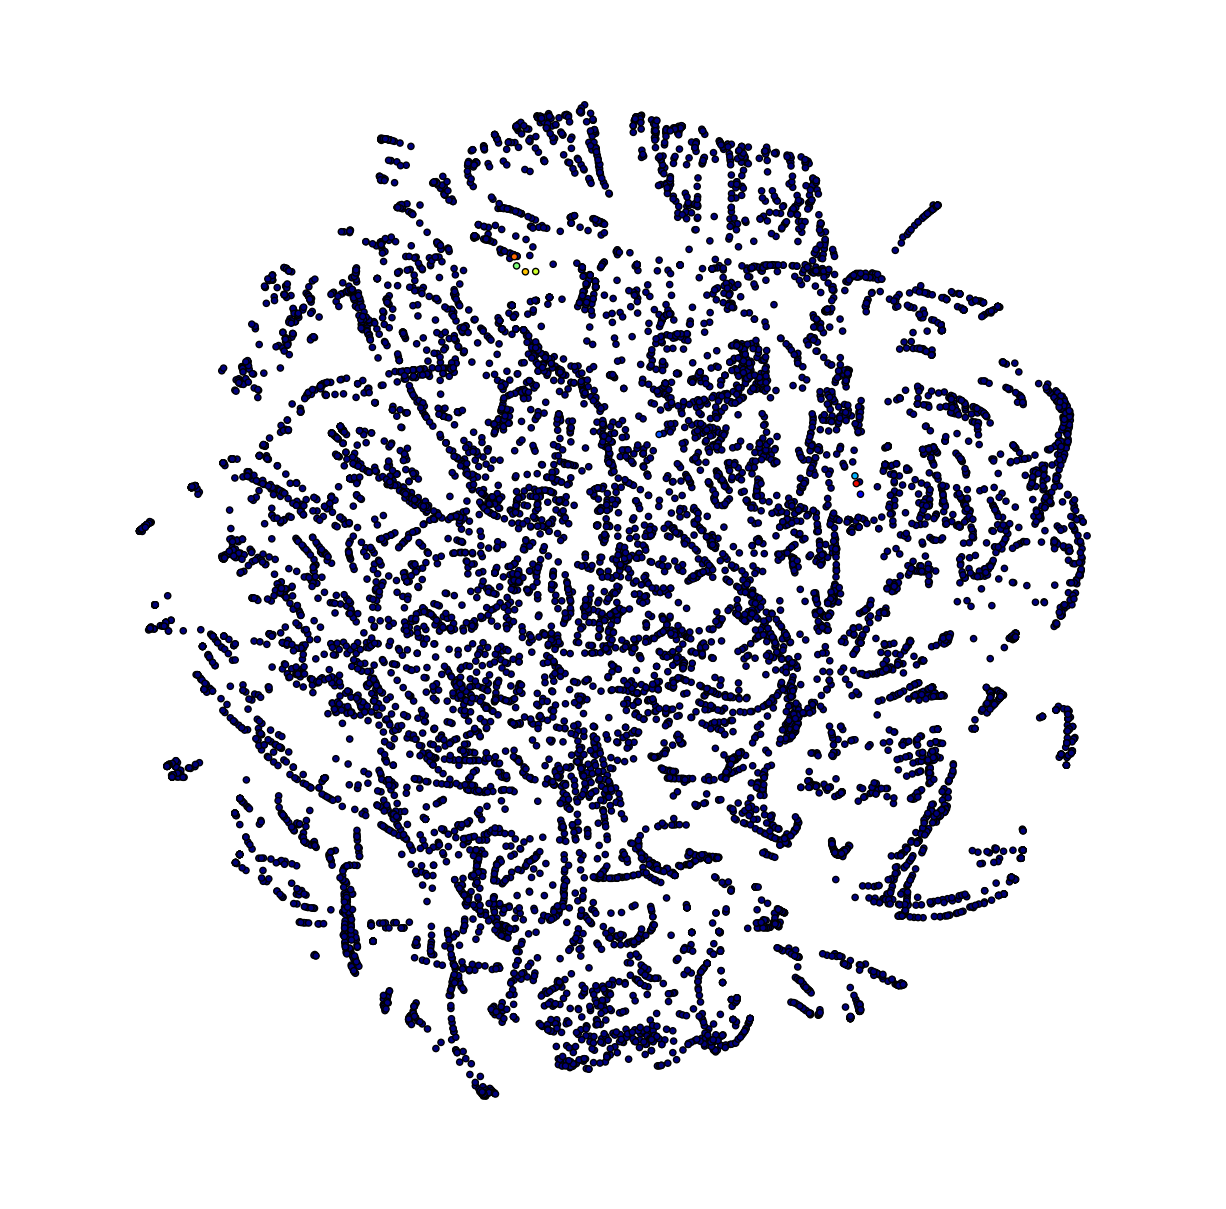

In [86]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

Как видим, все плохо. Алгоритм плохо реагирует на шум (точнее никак) и дальние на самом деле шумовые точки посчитал за кластера. Очень долго докидывал в один кластер и пересчитывал расстояния. И в итоге мы никакой полезной информации не получили. То есть для данной выборки этот алгоритм бесполезен.

ValueError: num must be 1 <= num <= 9, not 10

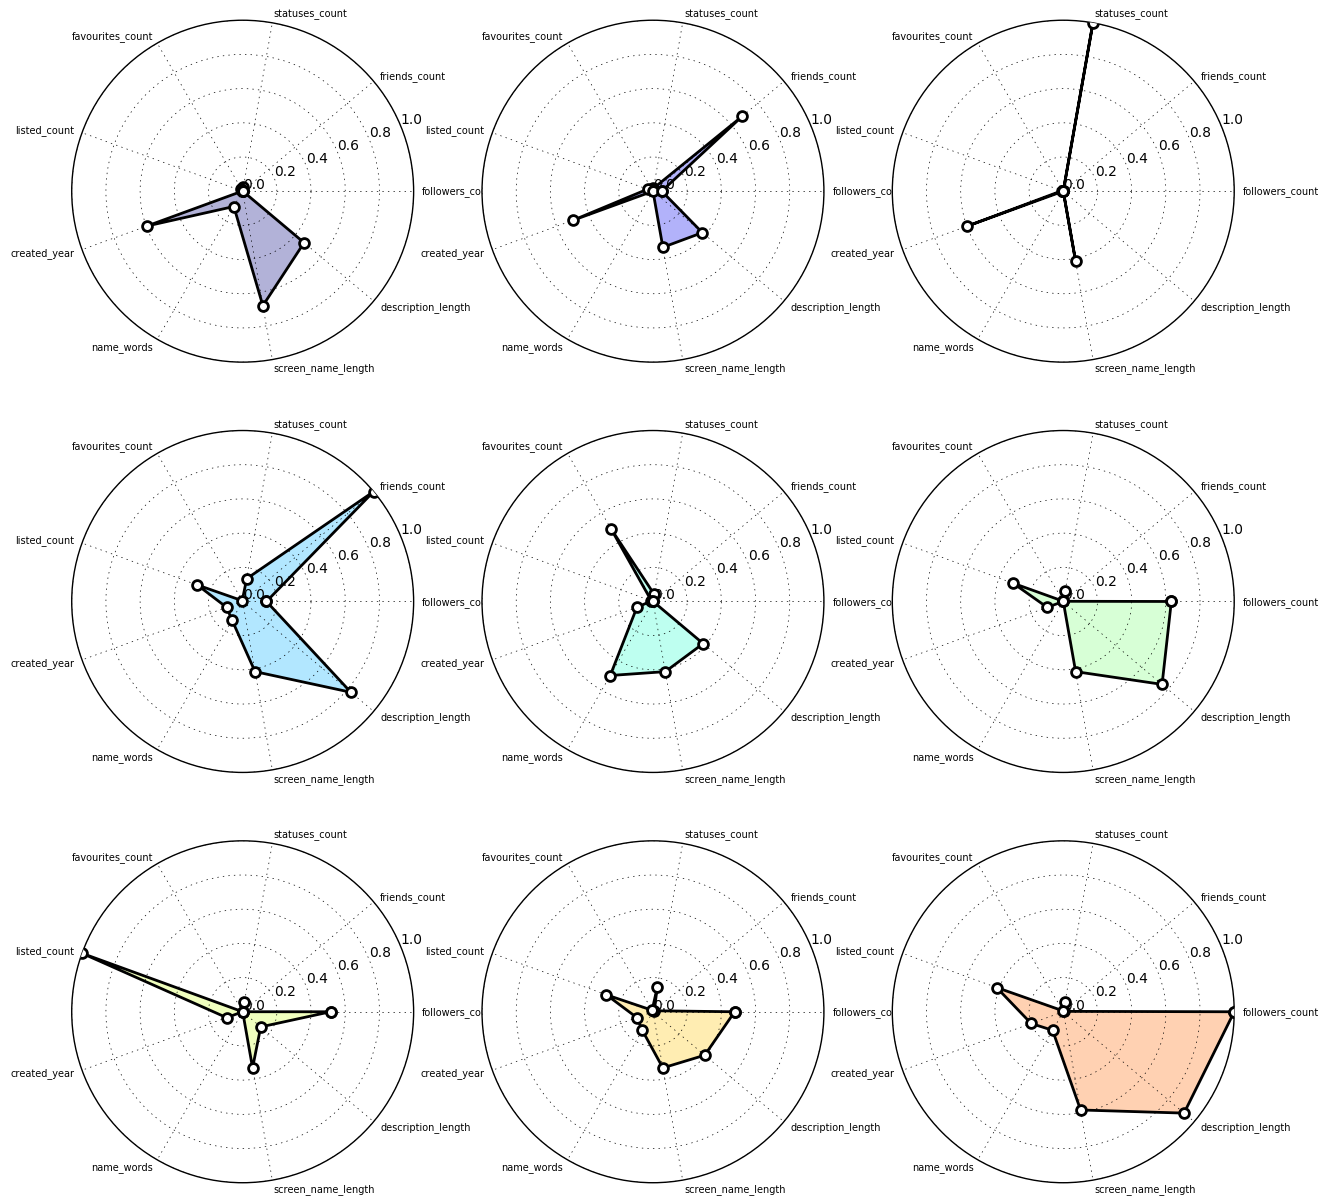

In [89]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.